# Task 2 - Generalist

In [1]:
# imports framework
import sys

from evoman.environment import Environment
from demo_controller import player_controller

# imports other libs
import numpy as np
import os
import math
import itertools
import scipy.stats as stats
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

pygame 2.5.2 (SDL 2.28.3, Python 3.10.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Input variables

In [2]:
enemies =  [1,2,3,7,8] 
method_version = 2  # 1 or 2
hyperparameter_tune_bool = 0 # 1 if tuning on parameter grid on, 0 otherwise
fitness_sharing_bool = 0

## Algorithm

In [3]:
# runs simulation
def simulation(env,x):
    f,p,e,t = env.play(pcont=x)
    return f

In [4]:
# evaluation
def evaluate(env, x):
    return np.array(list(map(lambda y: simulation(env,y), x)))

In [5]:
# runs simulation
def fintess_function_v2(fitness_list, playerlife_list, enemylife_list, time_list):
    total_fitness = 0
    kill_counter = 0
    for f,p,e,t in zip(fitness_list, playerlife_list, enemylife_list, time_list):
        if e == 0:
            kill_counter += 1
        total_fitness += f 
    return max(0,total_fitness * (1.5**kill_counter))

def evaluate_custom_ind(env, ind):
    original_enemies = env.enemies
    original_multiplemode = env.multiplemode
    env.multiplemode = "no"
    fitness_list, playerlife_list, enemylife_list, time_list = [], [], [], []

    for enemy in range(1,9):
        env.enemies = [enemy]
        f,p,e,t = env.play(pcont = ind)
        fitness_list.append(f)
        playerlife_list.append(p)
        enemylife_list.append(e)
        time_list.append(t)

    env.enemies = original_enemies
    env.multiplemode = original_multiplemode
    
    return fintess_function_v2(fitness_list, playerlife_list, enemylife_list, time_list)

def evaluate_custom_pop(env, pop):
    return np.array(list(map(lambda y: evaluate_custom_ind(env,y), pop)))

In [6]:
# choose this for not using visuals and thus making experiments faster
headless = True
if headless:
    os.environ["SDL_VIDEODRIVER"] = "dummy"


experiment_name = 'optimization_test'
if not os.path.exists(experiment_name):
    os.makedirs(experiment_name)

n_hidden_neurons = 10

# initializes simulation in individual evolution mode, for single static enemy.
env = Environment(experiment_name=experiment_name,
                enemies=enemies,
                playermode="ai",
                player_controller=player_controller(n_hidden_neurons), # you  can insert your own controller here
                enemymode="static",
                multiplemode = "yes",
                level=2,
                speed="fastest",
                visuals=False)


# number of weights for multilayer with 10 hidden neurons
n_vars = (env.get_num_sensors()+1)*n_hidden_neurons + (n_hidden_neurons+1)*5


MESSAGE: Pygame initialized for simulation.


### Initializating the population

Here we create a function that initialises the population randomly, resulting in a matrix of shape (10,265)

In [7]:
import random

random.seed(10)

###Initialization:
def initialize_population(population_size, lower, upper, n_vars):
    
    population = np.random.uniform(lower, upper, (population_size, n_vars))
    
    # Add alpha for recombination to population
    random_values = np.random.uniform(0, 1, (population_size, 1))
    population = np.hstack((population, random_values))
    # Add s for parent selection
    random_values = np.random.uniform(1, 2, (population_size, 1))
    population = np.hstack((population, random_values))
    #Add mutation_crossover_probability
    random_values = np.random.uniform(0, 1, (population_size, 1))
    population = np.hstack((population, random_values))
    
    return population



In [8]:
# New function to remove the hyperparameters
def remove_hyperparameters(population):
    # Assuming the hyperparameters are in the last column, remove it
    population_without_hyperparameters = population[:, :-3]
    return population_without_hyperparameters

### Choosing Parents

This is the first method, where a set of parents is chosen based on linear ranking with s = 1.5. The value was set such that it gives all individuals a selection probability higher than 0, but still does not put too much selection pressure.

In [9]:
###Choosing Parents version 1 - Linear Ranking
def select_parents_v1(pop, pop_fit, set_size, n_sets):
    
    #Population size
    population_size = pop.shape[0]

    #This is a scaling parameter (the higher the higher probabilty we give to the best fitness (1 < s <= 2))
    s = 1.5
    s = np.full(population_size, s)

    #The rank of how good the fitness is ranked low to high
    pop_rank = pop_fit.argsort()
    
    # Probability based on the linear ranking function
    first_part = ((2-s)/population_size)
    print(' first part', first_part)
    first_part = np.full(population_size, first_part)
    prob_rank = first_part + ((2*pop_rank)*(s-1)/(population_size*(population_size-1)))
    
    #Fill the indecies of the parents
    parent_indices = []
    for i in range(n_sets):
        parent_indices_tmp = (np.random.choice(np.arange(0,population_size), set_size, p=prob_rank, replace=False))
        parent_indices_tmp = parent_indices_tmp.tolist()
        parent_indices.append(parent_indices_tmp)
        
    parents = pop[parent_indices]

    return parents

In [10]:
def fitness_sharing(pop,pop_fit, sigma, alpha):
    population_size = len(pop)
    shared_fitness = np.zeros(len(pop_fit))
    
    for i in range(population_size):
        for j in range(population_size):
            #if i != j:
            # Calculate the Euclidean distance between weight vectors i and j
            d = np.sqrt(np.sum((pop[i] - pop[j])**2))
                
            # Calculate the sharing function sh(d)
            if d < sigma:
                sharing_value = 1 - (d / sigma)**alpha
            else:
                sharing_value = 0
                
            # Update the shared fitness for individual i
            shared_fitness[i] += sharing_value
    
    # Calculate the shared fitness for each individual
    
    shared_fitness =pop_fit/ np.sum(shared_fitness)
    return shared_fitness

In [11]:
def select_parents_v2_fitness_sharing(pop, pop_fit, set_size, n_sets):
    print("Selecting parents with FITNESS SHARING")
    
    #Population size
    population_size = pop.shape[0]

    #This is a scaling parameter (the higher the higher probabilty we give to the best fitness (1 < s <= 2))
    s1 = np.average([arr[-2] for arr in pop])
    s = np.full(population_size, s1)

    #Here create the fitness sharing function
    sigma = 3 #Random value based on the distance calculation
    alpha = 1 #Making the function linear
    shared_fitness = fitness_sharing(pop,pop_fit, sigma, alpha)

#     for i in range(0,40):
#         for j in range(0,10):
#             print(i, j, ": ", np.sqrt(np.sum((pop[i] - pop[j])**2)), "fitness", i, ": ", pop_fit[i], "fitness", j, ": ", pop_fit[j])

    # Rank individuals based on shared fitness
    pop_rank = np.argsort(shared_fitness)

    #The rank of how good the fitness is ranked low to high
    #pop_rank = pop_fit.argsort()
    
    # Probability based on the linear ranking function (The best fitness has the highest probability)
    first_part = ((2-s)/population_size)
    first_part = np.full(population_size, first_part)
    #print('first part', first_part)
    #print('pop_rank', pop_rank)
    #print('s', s)
    prob_rank = first_part + ((2*pop_rank)*(s-1)/(population_size*(population_size-1)))

    #Reversed order aka reversed prob function (The worst fitness has the highest probability)
    pop_rank_2 = pop_rank[::-1]
    prob_rank2 = first_part + ((2*pop_rank_2)*(s-1)/(population_size*(population_size-1)))

    #Elitest parents 10% of the population
    elite_parents = pop[pop_rank_2[0:int(population_size*0.1)]]
    elite_parents_fit = pop_fit[pop_rank_2[0:int(population_size*0.1)]]
    pop_wo_elite = pop[pop_rank_2[int(population_size*0.1)::]]
    pop_fit_wo_elite = pop_fit[pop_rank_2[int(population_size*0.1)::]]
    
    #Fill the indecies of the parents
    parent_indices = []
    for i in range(n_sets):
        parent_indices_parent1 = (np.random.choice(np.arange(0,population_size), 1, p=prob_rank, replace=False))
        parent_indices_parent2 = (np.random.choice(np.arange(0,population_size), 1, p=prob_rank2, replace=False))
        if parent_indices_parent1 == parent_indices_parent2:
            while parent_indices_parent1 == parent_indices_parent2:
                parent_indices_parent2 = (np.random.choice(np.arange(0,population_size), 1, p=prob_rank2, replace=False))
        parent_indices_tmp = np.concatenate((parent_indices_parent1, parent_indices_parent2))
        parent_indices_tmp = parent_indices_tmp.tolist()
        parent_indices.append(parent_indices_tmp)
        
    parents = pop[parent_indices]

    return parents, elite_parents, elite_parents_fit, pop_wo_elite, pop_fit_wo_elite, s1

The second method chooses the first parent from a normal linear ranking and the second parent based on inverse linear ranking. Meaning that the probability is calculated with inverse ranking, where it is in favour of the worst individual. Again the s is set to 1.5 to create selection probabilty for all individuals, without having too much selection pressure. As this function might result in less chance of reaching optimality, elitism is included as well.  

In [12]:
###Choosing Parents version 2 - Elitest + reversed probability function for remaining parents
def select_parents_v2(pop, pop_fit, set_size, n_sets):
    
    #Population size
    population_size = pop.shape[0]
    
#     s1 = 1.5
#     s = np.full(population_size, s1)

    #This is a scaling parameter (the higher the higher probabilty we give to the best fitness (1 < s <= 2))
    s1 = np.average([arr[-2] for arr in pop])
    s = np.full(population_size, s1)

    #The rank of how good the fitness is ranked low to high
    pop_rank = pop_fit.argsort()
    
    # Probability based on the linear ranking function (The best fitness has the highest probability)
    first_part = ((2-s)/population_size)
    first_part = np.full(population_size, first_part)
    prob_rank = first_part + ((2*pop_rank)*(s-1)/(population_size*(population_size-1)))

    #Reversed order aka reversed prob function (The worst fitness has the highest probability)
    pop_rank_2 = pop_rank[::-1]
    prob_rank2 = first_part + ((2*pop_rank_2)*(s-1)/(population_size*(population_size-1)))

    #Elitest parents 10% of the population
    elite_parents = pop[pop_rank_2[0:int(population_size*0.1)]]
    elite_parents_fit = pop_fit[pop_rank_2[0:int(population_size*0.1)]]
    pop_wo_elite = pop[pop_rank_2[int(population_size*0.1)::]]
    pop_fit_wo_elite = pop_fit[pop_rank_2[int(population_size*0.1)::]]
    
    #Fill the indecies of the parents
    parent_indices = []
    for i in range(n_sets):
        parent_indices_parent1 = (np.random.choice(np.arange(0,population_size), 1, p=prob_rank, replace=False))
        parent_indices_parent2 = (np.random.choice(np.arange(0,population_size), 1, p=prob_rank2, replace=False))
        if parent_indices_parent1 == parent_indices_parent2:
            while parent_indices_parent1 == parent_indices_parent2:
                parent_indices_parent2 = (np.random.choice(np.arange(0,population_size), 1, p=prob_rank2, replace=False))
        parent_indices_tmp = np.concatenate((parent_indices_parent1, parent_indices_parent2))
        parent_indices_tmp = parent_indices_tmp.tolist()
        parent_indices.append(parent_indices_tmp)
        
    parents = pop[parent_indices]
    

    return parents, elite_parents, elite_parents_fit, pop_wo_elite, pop_fit_wo_elite, s1

### Creating Offsprings

This function creates offsprings. For the code to run smoothly, the number of offsprings we create is 1 offspring per set of parents and the total number of offsprings is equal to the number of sets of parents we created before. 

The offpsirng is created by choosing a random crossover point for the parents and taking the first n genes from parent 1 and last len-n genes from parent 2. 

In [13]:
def create_offspring(parents, n_parent_sets, env, alphas, mutation_crossover_probability):
    offspring = np.empty((n_parent_sets, parents.shape[2]))
    offspring_fitness = np.zeros(n_parent_sets)
    
    #We want n_offspring = 3
    for i in range(n_parent_sets):
        # select parent
        parent_1 = parents[i][0]
        parent_2 = parents[i][1]
        
        #mutation_crossover_probability = parent_1[-1]
        

        if np.random.uniform(0, 1) < mutation_crossover_probability:
            #write code for a mutation function
            mutation_type = np.random.choice(['random', 'gaussian'])    
            if mutation_type == 'random':
                #random mutation
                mutation_point = np.random.randint(parents.shape[2])
                offspring[i] = parent_1
                offspring[i][mutation_point] = np.random.uniform(-1, 1)
            else:
                #gaussian mutation
                mutation_point = np.random.randint(parents.shape[2])
                offspring[i] = parent_1
                offspring[i][mutation_point] = np.random.normal(parent_1[mutation_point], 0.5)
        else:
            # Decide which crossover type to use for the current offspring
            #We can also do 2 kids crossover, 1 kid arithmetic. But random choice might also be nice?
            crossover_type = np.random.choice(['n-point', 'arithmetic'])
            if crossover_type == 'n-point':
                for idx, (a,b) in enumerate(zip(np.split(parent_1[:265],53), np.split(parent_2[:265],53))):
                    prob = np.random.uniform()
                    if prob<0.5:
                        offspring[i][idx*5 : (idx+1)*5] = np.array(a)
                    else:
                        offspring[i][idx*5 :(idx+1)*5] = np.array(b)
                offspring[i][265] = parent_1[265]
                offspring[i][266] = parent_2[266]
            else:
                # Arithmetic crossover
                alpha = parent_1[-3]
                alphas.append(alpha)
                offspring[i] = alpha * parent_1 + (1 - alpha) * parent_2


    offspring_fitness = evaluate_custom_pop(env, remove_hyperparameters(offspring))
    #offspring_fitness = evaluate(env, remove_hyperparameters(offspring))
    return offspring_fitness, offspring, alphas

### Survival Selection

The selection algorithm uses the Round Robin survival selection. 

In [15]:
#Fight function for round robbin
def fightFunction(individual_fit, opponent_fit):
    #implement winning condition here
    return individual_fit >= opponent_fit #return 1 if true else 0 

In [16]:
#Round Robin for method 1
def selectionRoundRobin_v1(env, pop, pop_fit, offspring, offspring_fit, pop_size, q):
    totalSelectionGroup = np.vstack((pop,offspring))
    totalSelectionGroup_fit = np.concatenate([pop_fit,offspring_fit])

    scoringOfIndividual = dict()
    #for each individual 
    for index, individual in enumerate(totalSelectionGroup_fit):
        #select q opponents
        opponents = np.random.choice(totalSelectionGroup_fit, size = q, replace= False)
        winCounter = 0 
        
        for opponent in opponents:
                winCounter += fightFunction(individual, opponent)

        scoringOfIndividual[index] = winCounter

    #sort the based on win counts
    sortedScoringOfIndividual = {k: v for k, v in sorted(scoringOfIndividual.items(), key=lambda item: item[1], reverse= True)}
    bestIndividualsIndices = list(sortedScoringOfIndividual.keys())[:pop_size]
    return totalSelectionGroup[bestIndividualsIndices], totalSelectionGroup_fit[bestIndividualsIndices]

In [17]:
#Round Robin for method 2
def selectionRoundRobin_elite_v2(env, pop, pop_fit, elite_parents, elite_parents_fit, pop_wo_elite, pop_wo_elite_fit, offspring, offspring_fit, pop_size, q):
    pop_size = pop_size-elite_parents.shape[0]
    #Combine the original population (parents) and the offsprings into one new one (new total population)
    totalSelectionGroup = np.vstack((pop_wo_elite,offspring))
    totalSelectionGroup_fit = np.concatenate([pop_wo_elite_fit,offspring_fit])
    
    scoringOfIndividual = dict()
    #for each individual 
    for index, individual in enumerate(totalSelectionGroup_fit):
        #select q opponents
        opponents = np.random.choice(totalSelectionGroup_fit, size = q, replace= False)
        winCounter = 0 
        
        for opponent in opponents:
                winCounter += fightFunction(individual, opponent)

        scoringOfIndividual[index] = winCounter

    #sort the based on win counts
    sortedScoringOfIndividual = {k: v for k, v in sorted(scoringOfIndividual.items(), key=lambda item: item[1], reverse= True)}
    bestIndividualsIndices = list(sortedScoringOfIndividual.keys())[:pop_size]
    
    new_pop = totalSelectionGroup[bestIndividualsIndices]
    new_pop_fit = totalSelectionGroup_fit[bestIndividualsIndices]

    #Add elitists to the survivors
    new_pop = np.concatenate((new_pop, elite_parents), axis = 0)
    new_pop_fit = np.concatenate((new_pop_fit, elite_parents_fit), axis=0)

    return new_pop, new_pop_fit

## Parameter tuning and results

In [18]:
#write code that calculates the fitness of the population for each of these hyperparameter combinations
# Define a function to evaluate hyperparameters
def evaluate_hyperparameters(hyperparameters, lower, upper, method_version):
    
    alphas = []
    ss = []
    fitness_values_per_gen = []
    # Modify your environment or model setup based on the hyperparameters
    population_size = hyperparameters['population_size']
    num_generations = hyperparameters['num_generations']
    #s = hyperparameters['s']
    q = hyperparameters['q']
    #n_offspring = hyperparameters['n_offspring']
    n_parent_sets = hyperparameters['n_parent_sets']
    mutation_crossover_probability = hyperparameters['mutation_crossover_probability']
    # ... (other hyperparameter modifications)

    # Run the genetic algorithm with the specified hyperparameters
    best_fitness = -float('inf')  # Initialize best fitness
    pop = initialize_population(population_size, lower, upper, n_vars)
    #add parameters for parameter control to pop?
    
    for generation in range(num_generations):
        #Creating an array of the fitness scores for the initialized population
        pop_fitness = evaluate_custom_pop(env, remove_hyperparameters(pop))
        #print(pop_fitness)
        parent_set_size = 2 #Number of parents for each offspring
        
        if method_version == 1:
            ####### PARENT SELECTION
            parents = select_parents_v1(pop, pop_fitness, parent_set_size, n_parent_sets)

            ###### OFFSPRINGS
            offspring_fitness, offspring = create_offspring(parents, n_parent_sets, env, alphas)

            ###### SURVIVOR SELECTION
            pop, pop_fit = selectionRoundRobin_v1(env, pop, pop_fitness, offspring, offspring_fitness, population_size, q)

        elif method_version == 2:
            ####### PARENT SELECTION
            if fitness_sharing_bool == 1:
                parents, elite_parents, elite_parents_fit, pop_wo_elite, pop_fit_wo_elite, s = select_parents_v2_fitness_sharing(pop, pop_fitness, parent_set_size, n_parent_sets)
                ss.append(s)
            else:
                parents, elite_parents, elite_parents_fit, pop_wo_elite, pop_fit_wo_elite, s = select_parents_v2(pop, pop_fitness, parent_set_size, n_parent_sets)
                ss.append(s)
            ###### OFFSPRINGS
            offspring_fitness, offspring, alphas = create_offspring(parents.squeeze(), n_parent_sets, env, alphas, mutation_crossover_probability)

            ###### SURVIVOR SELECTION
            pop, pop_fit = selectionRoundRobin_elite_v2(env, pop, pop_fitness, elite_parents, elite_parents_fit, pop_wo_elite, pop_fit_wo_elite, offspring, offspring_fitness, population_size, q)


        print("Generation:", generation, "Population:", pop.shape, "Population fitness:", pop_fit.shape)
        fitness_values_per_gen.append(pop_fit)
        
    # Calculate fitness for the last generation
    new_pop_fitness = evaluate_custom_pop(env, remove_hyperparameters(pop))
    #new_pop_fitness = evaluate(env, remove_hyperparameters(pop))
    #print(pop_fit)

    return new_pop_fitness, fitness_values_per_gen, pop, alphas, ss

### Hyperparameter tuning

In [19]:
#make a parameter grid
#param_grid = {
#   'population_size': [50, 100, 150],
#   'n_parent_sets': [10, 20, 30],
#   'n_offspring': [1, 2, 3],
#   'q': [10, 15, 20],
#   'num_generations': [10, 15, 20],
#}

In [20]:
#make a parameter grid
param_grid = {
    'population_size': [100],
    'n_parent_sets': [40],
    'q': [10],
    'num_generations': [60],
    'mutation_crossover_probability': [0.8],
}

In [22]:
def generate_hyperparameter_combinations(param_grid):
    hyperparameter_names = list(param_grid.keys())
    hyperparameter_values = list(param_grid.values())

    all_combinations = list(itertools.product(*hyperparameter_values))
    
    hyperparameter_combinations = []
    for combo in all_combinations:
        combo_dict = dict(zip(hyperparameter_names, combo))
        hyperparameter_combinations.append(combo_dict)
    
    return hyperparameter_combinations

In [23]:
if hyperparameter_tune_bool == 1:
    # Get all hyperparameter combinations
    all_hyperparameter_combinations = generate_hyperparameter_combinations(param_grid)

    # Print all combinations
    for i, combo in enumerate(all_hyperparameter_combinations):
        print("Hyperparameter Combination {}:".format(i+1), combo)
        print(combo)

In [24]:
if hyperparameter_tune_bool == 1:
    # Evaluate all hyperparameter combinations
    best_fitness = 0
    lower = -1
    upper = 1

    for hyperparameters in all_hyperparameter_combinations:
        pop_fitness, fitness_values_per_gen, pop, alphas, ss = evaluate_hyperparameters(hyperparameters, lower, upper, method_version)
        total_fitness = np.average(pop_fitness) # Calculate total fitness for the population on average, since initialization is already high!

        if total_fitness > best_fitness:
            best_fitness = total_fitness
            best_hyperparameters = hyperparameters
    print("Best Hyperparameters:", best_hyperparameters)
    highest_fitness = np.max(pop_fitness)   
    print("highest_fitness:", highest_fitness)
else:
    best_hyperparameters = {'population_size': 100, 'n_parent_sets': 40, 'q': 10, 'num_generations': 50, 'mutation_crossover_probability': 0.9}

### Run best parameters

In [25]:
best_params = best_hyperparameters

lower = -1
upper = 1

best10_individuals = []
all_10_fitnesses = []

for i in range(0,10):
    print("Run ", i)
    pop_fitness, fitness_array, pop, alphas, ss = evaluate_hyperparameters(best_params, lower, upper, method_version)

    total_fitness = np.average(pop_fitness)
    all_10_fitnesses.append(fitness_array)

    best_idx = np.argmax([pop_fitness])
    best10_individuals.append(pop[best_idx])


# Saves results
enems = "".join(map(str,enemies))
file_name_individuals = 'best10_individuals_method'+ str(method_version) + '_enemies'+ str(enems) +'.npy'
file_name_fitness = "best10_fitness_method"+ str(method_version) + '_enemies'+ str(enems) +".npy"
np.save(file_name_individuals, best10_individuals)
np.save(file_name_fitness, all_10_fitnesses)

Run  0
Generation: 0 Population: (100, 268) Population fitness: (100,)
Generation: 1 Population: (100, 268) Population fitness: (100,)
Generation: 2 Population: (100, 268) Population fitness: (100,)
Generation: 3 Population: (100, 268) Population fitness: (100,)
Generation: 4 Population: (100, 268) Population fitness: (100,)
Generation: 5 Population: (100, 268) Population fitness: (100,)
Generation: 6 Population: (100, 268) Population fitness: (100,)
Generation: 7 Population: (100, 268) Population fitness: (100,)
Generation: 8 Population: (100, 268) Population fitness: (100,)
Generation: 9 Population: (100, 268) Population fitness: (100,)
Generation: 10 Population: (100, 268) Population fitness: (100,)
Generation: 11 Population: (100, 268) Population fitness: (100,)
Generation: 12 Population: (100, 268) Population fitness: (100,)
Generation: 13 Population: (100, 268) Population fitness: (100,)
Generation: 14 Population: (100, 268) Population fitness: (100,)
Generation: 15 Population: (

## Island Model

In [ ]:
def islandDestruction(l, results_l, island_info): #Elimnate worst 20% islands
    n_pops = round(len(l)*0.2) 
    killed = 0
    min_num_islands = 5

    #sort islands list based on results
    rankings = results_l.values() #results_l = dict[island] = avg(pop_fit)
    sorted_islands = [x for _,x in sorted(zip(rankings, l))] # worst is first in list of islands
    while killed < n_pops and len(sorted_islands) > min_num_islands:
        #del island_info[sorted_islands[0]] # sorted_island[0] is the key of the killed island
        sorted_islands.pop(0)
        killed +=1
    eliminatedKeyList = [x for x in island_info.keys() if x not in sorted_islands]
    for eliminatedKey in eliminatedKeyList:
        del island_info[eliminatedKey]
    print(f"number of island destroyed: {killed}, island remaining: {len(sorted_islands)}, length of island_info: {len(island_info)}")
    
    return sorted_islands, island_info



def startIslandHopping(l, island_info): #Hop 10% of the individuals to another island
    if len(l) != len(island_info):
        raise ValueError("Number of islands and island info's must match")
    
    pop_size = len(island_info)
    new_island_info=[]
    shuffled_l = random.sample(l, k=len(l)) #Shuffled islands
    #print("Shuffled islands: "+str(shuffled_l))
    n_randomIndv = round(0.1*pop_size) #Number of individuals to swap
    #print("Number of individuals to be swapped:" + str(n_randomIndv))
    #print("Indices of to be swapped individuals: "+ str(random_idx))

    for donor, target in zip(l, shuffled_l):
        random_idx = random.sample(range(1, len(island_info[donor])-1), n_randomIndv) #Select n_randomIndv random individuals (indices)
        #print(donor, target)
        for n in random_idx:
            island_info[donor][n] = island_info[target][n]
        #new_island_info.append(island_info[donor])

    return island_info


In [ ]:
alphas = []
ss = []
fitness_values_per_gen = []
# Modify your environment or model setup based on the hyperparameters
population_size = 30
num_generations = 20
#s = hyperparameters['s']
q = 10
n_offspring = 2
n_parent_sets = 10
# ... (other hyperparameter modifications)

def algorithm(env, pop, pop_fit, alphas, mutation_crossover_probability):
    #do your algorithm thingy :3
    #Creating an array of the fitness scores for the initialized population
    pop_fitness = evaluate_custom_pop(env, remove_hyperparameters(pop))
    #print(pop_fitness)
    parent_set_size = 2 #Number of parents for each offspring

    ####### PARENT SELECTION
    parents, elite_parents, elite_parents_fit, pop_wo_elite, pop_fit_wo_elite, s = select_parents_elite_fitshare(pop, pop_fitness, parent_set_size, n_parent_sets)
    ss.append(s)
    ###### OFFSPRINGS
    offspring_fitness, offspring, alphas = create_offspring(parents.squeeze(), n_parent_sets, env, alphas, mutation_crossover_probability)
    ###### SURVIVOR SELECTION
    pop, pop_fit = selectionRoundRobin_elite(env, pop, pop_fitness, elite_parents, elite_parents_fit, pop_wo_elite, pop_fit_wo_elite, offspring, offspring_fitness, population_size, q)

    return pop, pop_fit

In [ ]:
def getBestPop(pop, pop_fit):
    return pop[np.argmax(pop_fit)], pop_fit[np.argmax(pop_fit)]

In [ ]:
lower = -2
upper = 2

results_l = dict()

island_info =dict() #stores the last population
best_pop_per_island = dict()
best_pop_fit_per_island = dict()


experiment_name = 'Tuning Task II'
if not os.path.exists(experiment_name):
    os.makedirs(experiment_name)
if not os.path.exists(experiment_name+"/island"):
    os.makedirs(experiment_name+"/island")

n_hidden_neurons = 10

# initializes simulation in individual evolution mode, for single static enemy.
env = Environment(experiment_name=experiment_name,
                enemies=[1,2,3,4,5,6,7,8],
                multiplemode="yes",
                playermode="ai",
                player_controller=player_controller(n_hidden_neurons), # you  can insert your own controller here
                enemymode="static",
                level=2,
                speed="fastest",
                visuals=False)

islandList_file = open(experiment_name+'/islandList.txt', 'r')
l = []
for line in islandList_file:
    l.append(tuple([eval(i) for i in line.split('\t')[:-1]]))
warmstart = True

if not os.path.exists(experiment_name+'/gen.txt'):
    global_gen_counter = 0
else:
    gen_file = open(experiment_name+'/gen.txt',)
    global_gen_counter = int(gen_file.readline())
    gen_file.close()

mutation_crossover_probability = 0.9

n_gens = 100 # hyper parameter
while global_gen_counter <= n_gens:
    for island in l:
        print(list(island))
        env.enemies = list(island) #update environment based on current island
        gen_counter = global_gen_counter
        
        isls = "".join(map(str,list(island)))
        pop = np.loadtxt(experiment_name + '/island' +'/island_'+ isls +'_pop.txt').tolist()
        pop = np.array([np.array(x) for x in pop])
        pop_fit = evaluate_custom_pop(env,remove_hyperparameters(pop))


        while gen_counter <= global_gen_counter+5:
            pop, pop_fit = algorithm(env, pop, pop_fit, alphas, mutation_crossover_probability)
            gen_counter +=1
        island_info[island] = pop 
        results_l[island] = np.average(pop_fit)
        best_pop_per_island[island], best_pop_fit_per_island[island] = getBestPop(pop, pop_fit)
        

    warmstart = False
    global_gen_counter += 5
    islandFile = open(experiment_name + "/islandList.txt", 'w+')
    islandFileFit = open(experiment_name + "/islandListPop.txt",'w+')
    for islandKey in l:
        isls = "".join(map(str,list(islandKey)))
        np.savetxt(experiment_name + '/island' +'/island_'+ isls +'_results.txt', best_pop_per_island[islandKey])
        np.savetxt(experiment_name + '/island' +'/island_'+ isls +'_pop.txt', island_info[islandKey])

        file_aux = open(experiment_name+'/gen.txt','w+')
        file_aux.write(str(global_gen_counter))
        file_aux.close()
        tempText = str(islandKey) + " : "  + str(best_pop_fit_per_island[islandKey]) + " \n"
        islandFileFit.write(tempText)

        for enemy in list(islandKey):
            islandFile.write(str(enemy)+ "\t")

        islandFile.write("\n")
    islandFile.close()
    islandFileFit.close()
    
    print(f"gen:{global_gen_counter} saved")

    frequency_of_destruction = 10 #note that always multiple of 5
    if global_gen_counter%frequency_of_destruction ==0:
        l, island_info = islandDestruction(l, results_l, island_info)

    if len(l) <= 50:
        #print(f"old islands: {island_info}")
        island_info = startIslandHopping(l,island_info)
        #print(f"new islands: {island_info}")

In [ ]:
import pandas as pd
last_sol = best_pop_per_island[((2, 3, 5, 6, 7, 8))][:265]
df_results_method1 = pd.DataFrame(columns = ["f", "player_life", "enemy_life", "time", 'enemy'])

for enemy in range(1, 9):
    env = Environment(experiment_name=experiment_name,
                  enemies=[enemy],
                  multiplemode="no",
                  playermode="ai",
                  player_controller=player_controller(10),
                  enemymode="static",
                  level=2,
                  speed="fastest",
                  visuals=False)
    f,p,e,t = env.play(pcont=last_sol)
    df_results_method1.loc[enemy-1,] = [f, p, e, t, enemy]
df_results_method1 = df_results_method1.set_index("enemy", inplace = False)

In [ ]:
np.savetxt("bestFile.txt", best_pop_per_island[((2, 3, 5, 6, 7, 8))][:265])

## Plots

In [ ]:
#Plot the s parameter
print(ss)
plt.plot(ss)

# Show the plot
plt.show()

In [ ]:
#Plot the alpha parameter 
print(alphas)
plt.plot(alphas)

# Show the plot
plt.show()

In [ ]:
# imports framework
import sys

from evoman.environment import Environment
from demo_controller import player_controller

# imports other libs
import numpy as np
import os
import math
import itertools
import scipy.stats as stats
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

In [ ]:
enemies = [2,3,5,6,7,8]
enems = "".join(map(str,enemies))

In [ ]:
def list_to_df(list_per_gen):
    df = pd.DataFrame()
    for idx, gen in enumerate(list_per_gen):
        col_name = idx
        df[col_name] = pd.Series(gen)

    return df

def df_to_aggregated(list_of_df, dfList_max):
    result = pd.DataFrame()
    for idx, df in enumerate(list_of_df):
        #col_name = "Method " + str(idx)
        col_name = "Method 1"

    for idx, df_max in enumerate(dfList_max):
        #col_name = "Method " + str(idx)
        col_name = "Method 1"

    result[str(col_name + " max")] = df_max.max()
    result[str(col_name + " avg")] = df.mean()

    return result

def plot_pipeline(list_of_fitness_per_generation):

    list_of_fitness_per_generation_avg = np.average(list_of_fitness_per_generation, axis=0) #Avg over 10 runs 
        
    #Get an array of all max within each iteration
    all_max_iter = []

    for i in range(0,10):
        temp_list = []
        for gen in list_of_fitness_per_generation[i]:
            temp_list.append(np.max(gen))
        all_max_iter.append(temp_list)

    #This matrix has the max fitness for each iteration in each generation [[max from all 10 runs in gen 1], [max from all 10 runs in gen 2], ...]
    all_max_iter_aranged = []

    for i in range(0, len(list_of_fitness_per_generation[0])):
        temp_list = []
        for j in range(0, len(list_of_fitness_per_generation)):
            temp_list.append(all_max_iter[j][i])
        all_max_iter_aranged.append(temp_list)

    std_dev_all_max_iter_aranged = np.std(all_max_iter_aranged, axis=1)

    dfList = []
    dfList_max = []
    dfList.append(list_to_df(list_of_fitness_per_generation_avg))
    dfList_max.append(list_to_df(all_max_iter_aranged))
    print(dfList)
    aggregated = df_to_aggregated(dfList, dfList_max)
    print("aggregated:", aggregated)
    n = len(aggregated)
    enemy_num = 5
    sb.set_theme()
    title = "Task I: enemy" + str(enemy_num)
    ax = sb.lineplot(data = aggregated, linewidth = 1, dashes= False)
    test = dfList[0].stack().reset_index()
    test = test.rename(columns={"level_1": "generation", "level_0": "individual_index", 0:"fitness"})
    sb.lineplot(data = test, x = "generation", y = "fitness")
    #Add Confidence interval for the data in all_max_iter_aranged 
    ax.fill_between(range(0, n), aggregated['Method 1 max'] - std_dev_all_max_iter_aranged, aggregated['Method 1 max']  + std_dev_all_max_iter_aranged, alpha=0.2)
    #Add fillbetween line for std_dev_all_max_iter_aranged
    #ax.fill_between(range(0, n), np.max(all_max_iter_aranged) - std_dev_all_max_iter_aranged, np.max(all_max_iter_aranged) + std_dev_all_max_iter_aranged, alpha=0.2)
    #sb.lineplot(aggregated)
    ax.set_xlabel("Generation" , fontsize = 25)
    ax.set_ylabel("Fitness", fontsize = 25)
    ax.axes.set_title(title,fontsize=20)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)

    ax.set_yticks([x for x in range(0,100+1, round(100/5))])

    #ax.legend()
    ax.margins(x=0.025)
    plt.show()

In [35]:
file_name = 'fitnessavg.txt'
fitnessavgArray = np.loadtxt(file_name)

file_name2 = 'fitnessmax.txt'
fitnessmaxArray = np.loadtxt(file_name2)

In [56]:
#María version
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

def list_to_df(list_per_gen):
    df = pd.DataFrame()
    for idx, gen in enumerate(list_per_gen):
        col_name = idx
        df[col_name] = pd.Series(gen)

    return df

def df_to_aggregated(list_of_df, dfList_max):
    result = pd.DataFrame()
    for idx, df in enumerate(list_of_df):
        #col_name = "Method " + str(idx)
        col_name = "Method 2"

    for idx, df_max in enumerate(dfList_max):
        #col_name = "Method " + str(idx)
        col_name = "Method 2"

    result[str(col_name + " max")] = df_max.max()
    result[str(col_name + " avg")] = df.mean()

    return result

def plot_pipeline(list_of_fitness_per_generation, fitnessavgArray, fitnessmaxArray):

    list_of_fitness_per_generation_avg = np.average(list_of_fitness_per_generation, axis=0) #Avg over 10 runs 
        
    #Get an array of all max within each iteration
    all_max_iter = []

    for i in range(0,10):
        temp_list = []
        for gen in list_of_fitness_per_generation[i]:
            temp_list.append(np.max(gen))
        all_max_iter.append(temp_list)

    #This matrix has the max fitness for each iteration in each generation [[max from all 10 runs in gen 1], [max from all 10 runs in gen 2], ...]
    all_max_iter_aranged = []

    for i in range(0, len(list_of_fitness_per_generation[0])):
        temp_list = []
        for j in range(0, len(list_of_fitness_per_generation)):
            temp_list.append(all_max_iter[j][i])
        all_max_iter_aranged.append(temp_list)

    std_dev_all_max_iter_aranged = np.std(all_max_iter_aranged, axis=1)

    dfList = []
    dfList_max = []
    dfList.append(list_to_df(list_of_fitness_per_generation_avg))
    dfList_max.append(list_to_df(all_max_iter_aranged))
    print(dfList)
    aggregated = df_to_aggregated(dfList, dfList_max)
    print("aggregated:", aggregated)
    n = len(aggregated)
    enemy_num = enems


    sb.set_theme()
    title = "Enemies " + str(enemy_num)


    ax = sb.lineplot(data = aggregated, linewidth = 1, dashes= False)
    test = dfList[0].stack().reset_index()
    test = test.rename(columns={"level_1": "generation", "level_0": "individual_index", 0:"fitness"})
    sb.lineplot(data = test, x = "generation", y = "fitness")
    #Add Confidence interval for the data in all_max_iter_aranged 
    ax.fill_between(range(0, n), aggregated['Method 2 max'] - std_dev_all_max_iter_aranged, aggregated['Method 2 max']  + std_dev_all_max_iter_aranged, alpha=0.2)
    #Add fillbetween line for std_dev_all_max_iter_aranged
    #ax.fill_between(range(0, n), np.max(all_max_iter_aranged) - std_dev_all_max_iter_aranged, np.max(all_max_iter_aranged) + std_dev_all_max_iter_aranged, alpha=0.2)
    #sb.lineplot(aggregated)
    ax = sb.lineplot(fitnessavgArray)
    ax = sb.lineplot(fitnessmaxArray)
    ax.set_xlabel("Generation" , fontsize = 25)
    ax.set_ylabel("Fitness", fontsize = 25)
    ax.axes.set_title(title, fontsize=20)
    #ax.legend(["Method 1 average", "Method 1 max", "Method 2 average", "Method 2 max", "ba"])
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)

    #ax.set_yticks([x for x in range(0,100+1, round(100/5))])

    ax.legend()
    ax.margins(x=0.025)
    plt.show()

    return dfList_max

[            0           1           2           3           4           5    
0   107.763917  184.243108  273.093602  285.094854  369.468489  415.969391  \
1    88.117505  163.618226  233.490617  244.872507  352.911770  392.082383   
2    55.776712  127.284871  214.367323  282.190699  322.474880  383.104840   
3    38.553298   87.617682  181.143158  261.714663  313.324639  368.988050   
4    32.949080   69.314484  121.121494  208.579646  291.568999  367.579071   
..         ...         ...         ...         ...         ...         ...   
95  247.795167  309.022584  350.763355  397.168167  464.511362  475.202859   
96  221.678259  281.501059  344.327592  364.110086  456.629726  468.227243   
97  178.835982  256.416951  326.283818  350.834266  432.559188  459.551489   
98  147.026323  216.098086  287.246035  340.357569  406.111339  454.739929   
99  126.982154  195.352668  282.585726  317.789755  387.325639  438.318578   

            6           7           8           9   ...       

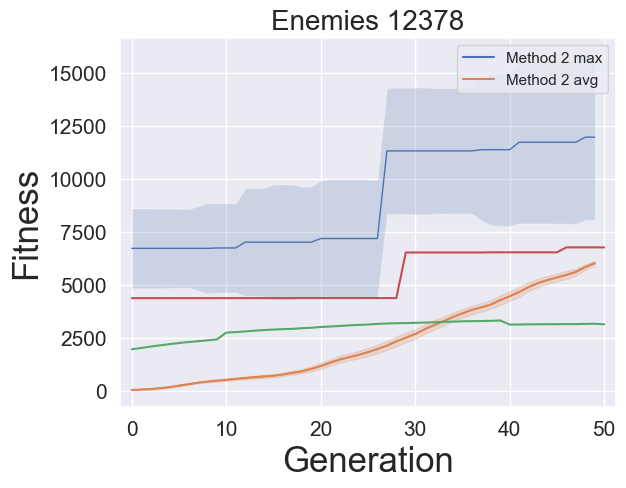

[            0            1            2            3            4    
 0  6731.743760  6731.743760  6731.743760  6731.743760  6731.743760  \
 1   535.920181   535.920181   535.920181   681.413341   681.413341   
 2   521.747942   521.747942   521.747942   521.747942   521.747942   
 3   481.730818   481.730818   495.516781   495.516781   495.516781   
 4   453.652368   453.652368   453.652368   453.652368   453.652368   
 5   454.467739   454.467739   454.467739   454.467739   454.467739   
 6   505.567615   505.567615   505.567615   505.567615   505.567615   
 7   435.881726   435.881726   435.881726   454.900136   454.900136   
 8   454.465230   454.465230   454.465230   455.552688   655.636625   
 9   360.795079   467.812606   467.812606   467.812606   467.812606   
 
             5            6            7            8            9   ...   
 0  6731.743760  6731.743760  6731.743760  6731.743760  6748.998312  ...  \
 1   681.413341   681.413341   684.013342   694.466011   751.5174

In [57]:
loaded_array = np.load("best10_fitness_method2_enemies12378.npy")
plot_pipeline(loaded_array, fitnessavgArray, fitnessmaxArray)


### Gain Plots

In [ ]:
import pandas as pd
index = 0
results_df =pd.DataFrame(columns=["fitness", "player_life", "enemy_life", "time", "method", "repetition", "enemy"]) 

experiment_name = 'test'
if not os.path.exists(experiment_name):
    os.makedirs(experiment_name)

for method in ['method1', 'method2']:
    file_name = 'best10_individuals_' + method + '_enemies' + str(enems) + '.npy'
    
    for enemy in enemies:
        solution = np.load(file_name)
        for iter_idx, iteration in enumerate(solution):
            env = Environment(
                    experiment_name=experiment_name,
                    enemies=[enemy],
                    playermode="ai",
                    fullscreen=False,
                    player_controller=player_controller(10),
                    enemymode="static",
                    level=2,
                    sound="off",
                    speed="fastest",
                    visuals=False)
            
            f, p, e, t = env.play(pcont=iteration)

            results_df.loc[index,] = [f, p, e, t, method, iter_idx, enemy]
            index +=1
results_df["gain"] = results_df["player_life"] - results_df["enemy_life"]

In [ ]:
# Create the boxplot.
ax = sb.boxplot(data=results_df, x="enemy", y="gain", hue="method")
ax.set_title("Gain per enemy per method", fontsize = 20)
#ax.set_xticklabels(["Enemy 2", "Enemy 3", "Enemy 5"], fontsize = 15)
ax.set_yticklabels(ax.get_yticks(), fontsize =15)
ax.set_xlabel(" ", fontsize = 20)
ax.set_ylabel("Gain", fontsize = 20)

### Defeat Table

file_name = 'best10_individuals_method1_enemies' + str(enems) + '.npy'
last_sol = np.load(file_name)[-1]
df_results_method1 = pd.DataFrame(columns = ["f", "player_life", "enemy_life", "time", 'enemy'])

for enemy in range(1, 9):
    env = Environment(experiment_name=experiment_name,
                  enemies=[enemy],
                  multiplemode="no",
                  playermode="ai",
                  player_controller=player_controller(10),
                  enemymode="static",
                  level=2,
                  speed="fastest",
                  visuals=False)
    f,p,e,t = env.play(pcont=last_sol)
    df_results_method1.loc[enemy-1,] = [f, p, e, t, enemy]
df_results_method1 = df_results_method1.set_index("enemy", inplace = False)

In [ ]:
df_results_method1[['player_life', 'enemy_life', 'time']].T

## Wilcoxon signed-rank test

In [ ]:
# Calculate the Wilcoxon signed-rank test between the methods for each enemy.
for enemy in enemies:
    set_1 = np.array(results_df[(results_df["method"] == "method1") & (results_df["enemy"] == enemy)]["gain"])
    set_2 = np.array(results_df[(results_df["method"] == "method2") & (results_df["enemy"] == enemy)]["gain"])
    test_statistic, p_value = stats.wilcoxon(set_1, set_2)
    print("p-value of wilcoxon test for enemy ",enemy, " ", p_value)
